(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Analyzing Hotel Ratings on Tripadvisor

In this homework we will focus on practicing two techniques: web scraping and regression. For the first part, we will get some basic information for each hotel in Boston. Then, we will fit a regression model on this information and try to analyze it.

** Task 1 (30 pts)**

We will scrape the data using Beautiful Soup. For each hotel that our search returns, we will get the information below.

![Information to be scraped](hotel_info.png)

Of course, feel free to collect even more data if you want. 

In [91]:
#import required libraries
from bs4 import BeautifulSoup
import sys
import time
import os
import logging
import argparse
import requests
import codecs
import json
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, StaleElementReferenceException, NoSuchElementException
from selenium.webdriver.support.expected_conditions import staleness_of
# from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.remote.webelement import WebElement
from selenium.webdriver import ActionChains

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy as sp
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
from scipy.spatial.distance import pdist, squareform

import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.utils as utils
import sklearn.linear_model as linear_model
import sklearn.cross_validation as cross_validation
import sklearn.cluster as cluster
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

import seaborn as sns
%matplotlib inline


Solution:
The whole task is done in steps:
    1. The first cell gets all hotel page urls in list nameurls along with hotel name in Hoteldf.
    2. Second cell request each hotel page and scrape the required traveller rating data in lists and eventually form Ratingdf.
    3. Third cell request each hotel page and scrape the required Review Type data in lists and eventually form Reviewdf.
    4. For last part of data collection of summary data, we call each hotel page url and get url for Show User Review page in fourth cell and store it in reviewpageurl.
    5. In Fifth cell, we used selenium driver to request each url from reviewpageurl and scarpe the data required into Dataframe and write it to Output.txt file also. (I am getting data only for Omni Parker House Hotel and using rest data provided.) 
 
     Commented part says about the code parts or has intermediate print statements , not needed to display.   

In [131]:
#Get all the Hotel name urls for boston, massachusetts

#define the source of scraping and user_agent
base_url = "http://www.tripadvisor.com"
user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/48.0.2564.116 Safari/537.36"
log = logging.getLogger(__name__)
log.setLevel(logging.ERROR)

loghandler = logging.StreamHandler(sys.stderr)
loghandler.setFormatter(logging.Formatter("[%(asctime)s] %(message)s"))
log.addHandler(loghandler)
# city and state to search on first page
city = "Boston"
state= "Massachusetts"

url = "%s/TypeAheadJson?query=%s%%20%s&action=API" % (base_url, "%20".join(city.split()), state)
log.info("URL TO REQUEST: %s \n" % url)
    
# Given the url, request the HTML page
headers = { 'User-Agent' : user_agent }
response = requests.get(url, headers=headers)
html = response.text.encode('utf-8')

# Parse json to get url
js = json.loads(html)
results = js['results']
log.info("RESULTS: %s \n " % results[0])
urls = results[0]['urls'][0]
log.info("URLS: %s \n " % urls)

# get tourism page url
tourism_url = urls['url']
log.info("TOURISM PAGE URL: %s \n" % tourism_url)

#print boston tourism page url
print ("Boston tourism page")
print tourism_url
time.sleep(2)


#Step 2
url1 = base_url + tourism_url
# Given the url, request the HTML page
response1 = requests.get(url1, headers=headers)
html1 = response1.text.encode('utf-8')
#use beautiful soup to get the web elements
soup = BeautifulSoup(html1)
li = soup.find("li", {"class": "hotels twoLines"})
city_url = li.find('a', href = True)
log.info("CITY PAGE URL: %s" % city_url['href'])
city_url1= city_url['href']
#print hotel list url for boston 
print("Hotel url")
print city_url1



#step 3
# get html of hotellist page
def get_hotellist_page(city_url2, count): 
    time.sleep(2)
    url2 = base_url + city_url2
    #print url2
    response2 = requests.get(url2, headers=headers)
    html = response2.text.encode('utf-8')
    #print html
    return html


#step 4
#use beautiful soup pto extract name url from each hotellist page
def parse_hotellist_page(html):
    soup1 = BeautifulSoup(html)
    # Extract hotel name, star rating and number of reviews
    hotel_boxes = soup1.findAll("div", {"class": "listing easyClear  p13n_imperfect "})
    for hotel_box in hotel_boxes:
        name = hotel_box.find("div", {"class": "listing_title"}).find('a', href=True)
        log.info("HOTEL NAME URL: %s" % name['href'])
        nameval= name.find(text=True)
        hotelname.append(nameval)
        nameurls.append(name['href'])
    # Get next URL page if exists, else raise stop Iteration exception to get out of while loop
    div = soup1.find("div", {"class" : "unified pagination standard_pagination"})
    # check if last page
    if (div.find("span", {"class" : "nav next ui_button disabled"})):
        print ("This is last page so calling system.exit")
        log.info("We reached last page")
        raise StopIteration()
    # If it is not last page there must be the Next URL
    hrefs = div.findAll('a', href= True)
    for href in hrefs:
        if href.find(text = True) == 'Next':
            log.info("Next url is %s" % href['href'])
            #print href['href']
            return href['href']

c=0
hotelname=[]
nameurls=[]

# call html request and parse method for hotellist page in while loop till stop iteration is triggered
try:
    while (True):
        c +=1
        html3 = get_hotellist_page(city_url1,c)
        city_url1 = parse_hotellist_page(html3)
except StopIteration:
    pass

#print all name urls list element along with name of hotel in Dataframe Hoteldf
hoteldf={"Hotel name":hotelname,"Urls":nameurls}
Hoteldf=pd.DataFrame(hoteldf)
print("----------------HOTEL NAME AND URLS-----------------")
print Hoteldf 
print Hoteldf.dtypes

Boston tourism page
/Tourism-g60745-Boston_Massachusetts-Vacations.html
Hotel url
/Hotels-g60745-Boston_Massachusetts-Hotels.html
This is last page so calling system.exit
----------------HOTEL NAME AND URLS-----------------
                                           Hotel name  \
0                                   Omni Parker House   
1                         Hyatt Regency Boston Harbor   
2                                Seaport Boston Hotel   
3                                  Hotel Commonwealth   
4                             The Westin Copley Place   
5                          Revere Hotel Boston Common   
6                               Sheraton Boston Hotel   
7                             InterContinental Boston   
8                   Nine Zero Hotel - a Kimpton Hotel   
9                                 Boston Harbor Hotel   
10                      Fairmont Copley Plaza, Boston   
11                       Boston Marriott Copley Place   
12                                 

In [132]:
print len(nameurls)

#Traveller Rating Data

#request html page for each hotel
def get_hotel_page(hotel_url): 
    time.sleep(2)
    url = base_url + hotel_url
    #print url
    response = requests.get(url, headers=headers)
    html = response.text.encode('utf-8')
    #print html
    return html

# parse html page for each hotel to get traveller rating and append it to corresponding lists
def parse_hotel_page(html):
    soup = BeautifulSoup(html)
    # Extract hotel name, star rating and number of reviews
    rating_col = soup.find("div", {"class": "col rating "})
    Excellent =rating_col.find("label", {"for": "taplc_prodp13n_hr_sur_review_filter_controls_0_filterRating_5"}).findAll("span")[2].text
    #print Excellent
    excellent.append(str(Excellent))
    VeryGood =rating_col.find("label", {"for": "taplc_prodp13n_hr_sur_review_filter_controls_0_filterRating_4"}).findAll("span")[2].text
    #print VeryGood
    verygood.append(str(VeryGood))
    Average =rating_col.find("label", {"for": "taplc_prodp13n_hr_sur_review_filter_controls_0_filterRating_3"}).findAll("span")[2].text
    #print Average
    average.append(str(Average))
    Poor =rating_col.find("label", {"for": "taplc_prodp13n_hr_sur_review_filter_controls_0_filterRating_2"}).findAll("span")[2].text
    #print Poor
    poor.append(str(Poor))
    Terrible =rating_col.find("label", {"for": "taplc_prodp13n_hr_sur_review_filter_controls_0_filterRating_1"}).findAll("span")[2].text
    #print Terrible
    terrible.append(str(Terrible))
    return True

#list declaration for storage     
excellent =[]
verygood= []
average = []
poor = []
terrible= []

# call html and parse function for each hotel 
for i in range(0,len(nameurls)):
    hotelhtml=get_hotel_page(nameurls[i])
    time.sleep(1)
    TravelRating = parse_hotel_page(hotelhtml)

# remove the /n from each element of list    
excellent = map(lambda s: s.strip(), excellent)
verygood = map(lambda s: s.strip(), verygood)
average = map(lambda s: s.strip(), average)
poor = map(lambda s: s.strip(), poor)
terrible = map(lambda s: s.strip(), terrible)

#remove the "," from each element of lists as needed to calculate average score later on 
excellent = map(lambda s: s.replace(',',''), excellent)
verygood = map(lambda s: s.replace(',',''), verygood)
average = map(lambda s: s.replace(',',''), average)
poor = map(lambda s: s.replace(',',''), poor)
terrible = map(lambda s: s.replace(',',''), terrible)

#convert to int type for average score calculation 
excellent = map(float, excellent)
verygood = map(float, verygood)
average = map(float, average)
poor = map(float, poor)
terrible = map(float, terrible)
hotelname = map(str, hotelname)
# print excellent
# print verygood
# print average
# print poor
# print terrible


#Dataframe for Traveller Rating Data
travelrating = {'Hotel name': hotelname,'Excellent': excellent,'Very Good':verygood,'Average':average,'Poor':poor,'Terrible':terrible}
Ratingdf=pd.DataFrame(travelrating)
print ("-------------TRAVELLER RATING DATA FOR BOSTON HOTELS---------------")
print Ratingdf


82
-------------TRAVELLER RATING DATA FOR BOSTON HOTELS---------------
    Average  Excellent                                         Hotel name  \
0       689       2495                                  Omni Parker House   
1       190        742                        Hyatt Regency Boston Harbor   
2       106       2630                               Seaport Boston Hotel   
3       101       2829                                 Hotel Commonwealth   
4       314       1316                            The Westin Copley Place   
5       224       1315                         Revere Hotel Boston Common   
6       146        424                              Sheraton Boston Hotel   
7       153       1589                            InterContinental Boston   
8       113       1349                  Nine Zero Hotel - a Kimpton Hotel   
9        48       1130                                Boston Harbor Hotel   
10      189       1218                      Fairmont Copley Plaza, Boston   
11   

In [133]:
print len(nameurls)

# Reviews Type

# parse function to get review type value  and append it to corresponding list
def parse_hotel_page_seg(html):
    soup = BeautifulSoup(html)
    
    segment_col = soup.find("div", {"class": "col segment "})
    Family =segment_col.find("label", {"for": "taplc_prodp13n_hr_sur_review_filter_controls_0_filterSegment_Family"}).find("span").text
    #print Family
    family.append(Family)
    Couples =segment_col.find("label", {"for": "taplc_prodp13n_hr_sur_review_filter_controls_0_filterSegment_Couples"}).find("span").text
    #print Couples
    couple.append(Couples)
    Solo =segment_col.find("label", {"for": "taplc_prodp13n_hr_sur_review_filter_controls_0_filterSegment_Solo"}).find("span").text
    #print Solo
    solo.append(Solo)
    Business =segment_col.find("label", {"for": "taplc_prodp13n_hr_sur_review_filter_controls_0_filterSegment_Business"}).find("span").text
    #print Business
    business.append(Business)
    Friends =segment_col.find("label", {"for": "taplc_prodp13n_hr_sur_review_filter_controls_0_filterSegment_Friends"}).find("span").text
    #print Friends
    friend.append(Friends)
    return True

#list global declaration     
family =[]
couple= []
solo = []
business = []
friend= []

#call html and aprse function for review type data
for i in range(0,len(nameurls)):
    hotelhtml=get_hotel_page(nameurls[i])
    time.sleep(2)
    Reviews = parse_hotel_page_seg(hotelhtml)

#remove the "(" and ")" from each element    
family = map(lambda s: s.replace('(','').replace(')',''), family)
couple = map(lambda s: s.replace('(','').replace(')',''), couple)
solo = map(lambda s: s.replace('(','').replace(')',''), solo)
business = map(lambda s: s.replace('(','').replace(')',''), business)
friend = map(lambda s: s.replace('(','').replace(')',''), friend)

#remove "," from each element
family = map(lambda s: s.replace(',',''), family)
couple = map(lambda s: s.replace(',',''), couple)
solo = map(lambda s: s.replace(',',''), solo)
business = map(lambda s: s.replace(',',''), business)
friend = map(lambda s: s.replace(',',''), friend)

#convert it to int type for calculation needed later on
family = map(float, family)
couple = map(float, couple)
solo = map(float, solo)
business = map(float, business)
friend = map(float, friend)

# print family
# print couple
# print solo
# print business
# print friend
#Dataframe for Review Type Data
review = {'Hotel name': hotelname, 'Family': family,'Couples':couple,'Solo':solo,'Business':business,'Friends':friend}
Reviewdf=pd.DataFrame(review)
print ("---------REVIEW TYPE DATA FOR BOSTON HOTELS-----------")
print Reviewdf

82
---------REVIEW TYPE DATA FOR BOSTON HOTELS-----------
    Business  Couples  Family  Friends  \
0       1322     1753    1156      421   
1        454      458     355       84   
2       1568      770     601      197   
3        702     1017    1110      208   
4        920      573     673      197   
5        403      754     533      309   
6        410      247     238       93   
7        664      851     527      193   
8        373      915     381      156   
9        294      525     327       78   
10       584      673     427      122   
11       842      483     474      147   
12       404     1043     687      241   
13       416      322     342       98   
14        81      126     134       36   
15       393      435     608      311   
16       105      295     188       96   
17       386      372     516      102   
18       236      365     196       94   
19       140      584     106       84   
20       295      274     266       86   
21       349      

In [134]:
print len(nameurls)
#get url for show user review for each hotel

#get html for each hotel url
def get_hotel_page2(hotel_url): 
    time.sleep(2)
    url = base_url + hotel_url
    #print url
    response = requests.get(url, headers=headers)
    html = response.text.encode('utf-8')
    #print html
    return html

#parse the html to get show user reiew url
def parse_hotel_review_page(html):
    soup = BeautifulSoup(html)
    review_col = soup.find("div", {"class": "quote"}).find('a', href=True)
#     print ("returning this url")
#     print review_col['href']
    return review_col['href']


#list to store review page url
reviewpageurl=[]

#call html and parse function for each hotel and get review page url for them
for i in range(0,len(nameurls)):
    hotelhtml=get_hotel_page2(nameurls[i])
    time.sleep(1)
    ReviewPage = parse_hotel_review_page(hotelhtml)
    reviewpageurl.append(ReviewPage)
    #print ReviewPage
    
#print the review page url    
print ("----LIST OF URLS OF REVIEW PAGES FOR BOSTON HOTELS")
print ("\n".join(reviewpageurl))

82
----LIST OF URLS OF REVIEW PAGES FOR BOSTON HOTELS
/ShowUserReviews-g60745-d89599-r359484392-Omni_Parker_House-Boston_Massachusetts.html#CHECK_RATES_CONT
/ShowUserReviews-g60745-d89620-r359555413-Hyatt_Regency_Boston_Harbor-Boston_Massachusetts.html#CHECK_RATES_CONT
/ShowUserReviews-g60745-d94330-r359524943-Seaport_Boston_Hotel-Boston_Massachusetts.html#CHECK_RATES_CONT
/ShowUserReviews-g60745-d258705-r359713730-Hotel_Commonwealth-Boston_Massachusetts.html#CHECK_RATES_CONT
/ShowUserReviews-g60745-d89617-r359497219-The_Westin_Copley_Place-Boston_Massachusetts.html#CHECK_RATES_CONT
/ShowUserReviews-g60745-d89600-r359525361-Revere_Hotel_Boston_Common-Boston_Massachusetts.html#CHECK_RATES_CONT
/ShowUserReviews-g60745-d89602-r359463105-Sheraton_Boston_Hotel-Boston_Massachusetts.html#CHECK_RATES_CONT
/ShowUserReviews-g60745-d620703-r359729596-InterContinental_Boston-Boston_Massachusetts.html#CHECK_RATES_CONT
/ShowUserReviews-g60745-d234752-r359690554-Nine_Zero_Hotel_a_Kimpton_Hotel-Boston

In [40]:
#chromedriver for selenium
path_to_chromedriver = 'chromedriver' # change path as needed

#webdriver instance of selenium
browser = webdriver.Chrome(executable_path = path_to_chromedriver)

print (len(reviewpageurl))

# parse each review data from each reviews for hotel
def parse_hotel_review_page_user(reviewurl):
    #write the data to text file
    with open('Output.txt', 'w') as text_file:
        url = base_url+reviewurl
        browser.get(url)
        while True:
            listof =browser.find_elements_by_class_name('  reviewSelector ')
            for i in range(0,len(listof)):
                idname =listof[i].get_attribute('id')
                li=listof[i].find_elements_by_class_name('recommend-answer')
                for i in range(0,len(li)):
#                     print idname
                    revid.append(idname)
                    att= li[i].find_element_by_class_name('recommend-description').text
                    val = li[i].find_element_by_tag_name('img').get_attribute('alt')
                    attr.append(att)
                    value.append(val[:1])
#                     print att
#                     print val[:1]
                    text_file.write("%s:%s:%s \n" % (idname,att,val[:1]))
            try:
                link = browser.find_element(By.CSS_SELECTOR, 'a.nav.next.rndBtn.ui_button.primary.taLnk')
                ActionChains(browser).move_to_element(link).click().perform();
                #check if next page is loaded
                def link_has_gone_stale():
                    try:
                        # poll the link with an arbitrary call
                        link.find_elements_by_css_selector('span.pageNum.current') 
                        return False
                    except StaleElementReferenceException:
                        return True
                #keep wiating till stale element 
                while not link_has_gone_stale():
                    WebDriverWait(browser, 30)
            except NoSuchElementException:
                break
    browser.close()
    return True

#list for revid, attr and value
revid=[]
attr=[]
value=[]

# call parsing using selenium for data  (only for one hotel as example) 
#It takes 35 minutes for selenium to get all data for omni parker house hotel
for i in range(0,1):
    brow= parse_hotel_review_page_user(reviewpageurl[i])

#Dataframe for Summary Data for one hotel   
summary = {'ReviewId': revid,'Attribute':attr,'Value':value}
Summarydf=pd.DataFrame(summary)
print Summarydf 
    

82
                                      Attribute          ReviewId Value
0                                         Value  review_358625594     5
1                                      Location  review_358625594     5
2                                 Sleep Quality  review_358625594     5
3                                         Rooms  review_358625594     5
4                                   Cleanliness  review_358625594     5
5                                       Service  review_358625594     5
6                                 Sleep Quality  review_358203371     2
7                                         Rooms  review_358203371     2
8                                       Service  review_358203371     3
9                                         Value  review_358150172     3
10                                  Cleanliness  review_358150172     5
11                                      Service  review_358150172     5
12                                        Value  review_35835

Instruction for selenium run:
The Fifth cell uses chromedriver for selenium which takes some *35 minutes* to finish scraping for Omni Parker House Hotel. Also on page 1 on clicking next it gives popup for sign in and at the footer navigation to next hotel option comes, we have to manually close both things as footer has same element property. After that it runs and finish collecting required data for all 5000 somethign reviews.

The file storing this data is Output.txt

** Task 2 (20 pts) **

Now, we will use regression to analyze this information. First, we will fit a linear regression model that predicts the average rating. For example, for the hotel above, the average rating is

$$ \text{AVG_SCORE} = \frac{1*31 + 2*33 + 3*98 + 4*504 + 5*1861}{2527}$$

Use the model to analyze the important factors that decide the $\text{AVG_SCORE}$.

Solution:
For this task, following are the steps :
1. Calcuate the Average Score for each Hotel using Traveller Ratings as defined in question in column Avg_Score.
2. Load the data file for Summary Details data and calculate weighted values for each attribute like Value, Location,Sleep Quality, etc. And append data of Omni Parker House Hotel in the same format.(Use the rating-summary.txt given in folder as i have changed the names of 5 hotel in file because instead of "&" and "/" it had unidentified symbols)
3. Combine all data from Ratingdf, summaryres and Reviewdf based on Hotel name into Finaldf and removing one tupple "Element Boston Seaport" from it which has Location data as Null. So the model data has 81 tupples for training Ordinary Linear Regression Model.
4. Using sklearn Linear Regression on same training data(81 hotels) to see the intercept values
5. Analyse the Model 

In [148]:
# print Ratingdf
# Calculate the Average score for each hotel in column 'Avg_Score'
Ratingdf['Avg_Score']= ((Ratingdf['Terrible'])*1+ (Ratingdf['Poor'])*2+(Ratingdf['Average'])*3+(Ratingdf['Very Good'])*4+(Ratingdf['Excellent'])*5)/((Ratingdf['Terrible'])+ (Ratingdf['Poor'])+(Ratingdf['Average'])+(Ratingdf['Very Good'])+(Ratingdf['Excellent']))
#This command is used to set index which is ran once only on dataframe . Once ran than this gives error.
Ratingdf=Ratingdf.set_index('Hotel name')
print Ratingdf.dtypes
#This command is used to set index which is ran once only on dataframe . Once ran than this gives error.
Reviewdf=Reviewdf.set_index('Hotel name')
print Reviewdf.dtypes


Average      float64
Excellent    float64
Poor         float64
Terrible     float64
Very Good    float64
Avg_Score    float64
dtype: object
Business    float64
Couples     float64
Family      float64
Friends     float64
Solo        float64
dtype: object


In [149]:
# Get the file for Summary data into summarydata DataFrame 
summarydata = pd.read_csv('rating-summary.txt', sep=":", header = None)
summarydata.columns = ["Hotel name", "Attribute", "Category", "Count"]
summarydata['Weighted']= summarydata['Category']*summarydata['Count']
# print summarydata
summarydata=summarydata.drop(['Category'],axis=1)

#Calculate Numerator and denominator for weighted values  
deno=summarydata.groupby(['Hotel name','Attribute'],sort=False)['Count'].sum().reset_index()
numo =summarydata.groupby(['Hotel name','Attribute'],sort=False)['Weighted'].sum().reset_index()
# print numo
# print deno

#Concat numerator and denominator to calculate AverageScore for each attribute for each hotel
summarise=pd.concat([numo, deno], axis=1)
summarise['AverageScore']=summarise['Weighted']/summarise['Count']
summarise=summarise.drop(['Weighted','Count'],axis=1)
#remove duplicate column
summarise=summarise.T.drop_duplicates().T
# print summarise.columns.values

#Get the Omni Parker house Hotel data scraped earlier
omnidf = pd.read_csv('Output.txt', sep=":", header = None)
omnidf.columns = ["ReviewId", "Attribute", "Value"]
omnidata=omnidf.groupby(['Attribute','Value']).count().reset_index()
omnidata['Weighted']= omnidata['Value'] * omnidata['ReviewId']
omnidata=omnidata.drop(['Value'],axis=1)
# print omnidata

#calculate numerator and denominator for weighted values 
omnideno=omnidata.groupby(['Attribute'],sort=False)['ReviewId'].sum().reset_index()
omninumo =omnidata.groupby(['Attribute'],sort=False)['Weighted'].sum().reset_index()
# print omninumo
# print omnideno

#merge numerator and denominator to calculate AverageScore for every attribute
omnisummarise=pd.merge(omninumo, omnideno, left_on = 'Attribute', right_on = 'Attribute')
omnisummarise['AverageScore']=omnisummarise['Weighted']/omnisummarise['ReviewId']
omnisummarise=omnisummarise.drop(['Weighted','ReviewId'],axis=1)
#append the hotel name to dataframe omnisummarise
omnisummarise["Hotel name"]= "Omni Parker House"
# print omnisummarise

#Append the Omni Parker House data to the rest of hotel data
summaryres = summarise.append([omnisummarise])
summaryres= summaryres.reset_index()
summaryres=summaryres.drop(['index'],axis=1)
# print summaryres

#remove the attributes not required
summaryres = summaryres.drop(summaryres[summaryres.Attribute == "Check in / front desk"].index)
summaryres = summaryres.drop(summaryres[summaryres.Attribute == "Business service (e.g., internet access)"].index)
summaryres= summaryres.reset_index()
summaryres=summaryres.drop(['index'],axis=1)
#Get the summary data in 82* 6 format where 6 attributes are there like Value, Location , Rooms, etc. 
summaryres=summaryres.pivot(index='Hotel name', columns='Attribute', values='AverageScore')

#convert all attribute values to float for summaryres
summaryres['Cleanliness'] = map(float, summaryres['Cleanliness'])
summaryres['Location'] = map(float, summaryres['Location'])
summaryres['Rooms'] = map(float, summaryres['Rooms'])
summaryres['Service'] = map(float, summaryres['Service'])
summaryres['Sleep Quality'] = map(float, summaryres['Sleep Quality'])
summaryres['Value'] = map(float, summaryres['Value'])
print (summaryres.dtypes)
print ("--------SUMMARY DATA FOR BOSTON HOTELS----------")
print summaryres
# print len(summaryres)

Attribute
Cleanliness      float64
Location         float64
Rooms            float64
Service          float64
Sleep Quality    float64
Value            float64
dtype: object
--------SUMMARY DATA FOR BOSTON HOTELS----------
Attribute                                           Cleanliness  Location  \
Hotel name                                                                  
Aloft Boston Seaport                                   4.166667  4.250000   
Americas Best Value Inn                                2.769231  2.636364   
Ames Boston Hotel                                      4.633113  4.760900   
BEST WESTERN PLUS Roundhouse Suites                    4.185028  3.261905   
BEST WESTERN University Hotel Boston-Brighton          3.873418  4.052219   
Battery Wharf Hotel, Boston Waterfront                 4.729730  4.595687   
Beacon Hill Hotel and Bistro                           4.384615  4.803571   
Boston Harbor Hotel                                    4.824275  4.818182   
Boston 

----------ORDINARY LINEAR REGRESSION MODEL-----------------
                            OLS Regression Results                            
Dep. Variable:              Avg_Score   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.921e+04
Date:                Tue, 29 Mar 2016   Prob (F-statistic):          1.29e-164
Time:                        23:52:39   Log-Likelihood:                 156.27
No. Observations:                 109   AIC:                            -280.5
Df Residuals:                      93   BIC:                            -237.5
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------

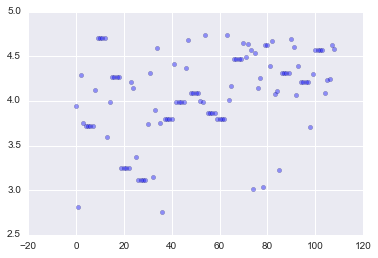

In [152]:
# # print Ratingdf
# print len(Ratingdf)
# print Ratingdf.columns.values
# print Ratingdf.index.values
# print type(Ratingdf.index.values[0])
# print Ratingdf.dtypes
# # print ("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
# # print summaryres
# print len(summaryres)
# print summaryres.columns.values
# print summaryres.index.values
# print type(summaryres.index.values[0])
# print summaryres.dtypes
# # print ("############################")
# # print Reviewdf
# print len(Reviewdf)
# print Reviewdf.columns.values
# print Reviewdf.index.values
# print type(Reviewdf.index.values[0])
# print Reviewdf.dtypes

#Merge all three Data parts into Finaldf on basis of hotel name which is index for all Dataframe
Finaldf=pd.merge(pd.merge(Ratingdf, summaryres, right_index=True, left_index=True),Reviewdf,right_index=True,left_index=True)
# Finaldf=Finaldf.drop(['Terrible','Poor','Average','Very Good','Excellent'],axis=1)

# print len(Finaldf)

# print Finaldf.columns.values
# print Finaldf.index.values
# print Finaldf.dtypes
# print Finaldf

#remove one tupple which has null value for one of the attribute into new DataFrame Finaldf_no_missing
Finaldf_no_missing = Finaldf.dropna() 
# print len(Finaldf_no_missing)
# print Finaldf_no_missing.dtypes

#Define y(dependent variable for Regression Model)
y= Finaldf_no_missing.Avg_Score;
# print y
# print type(y)
# print y.shape

#Define X(independent variable vectors or training data columns data for Regression) 
X=Finaldf_no_missing[['Cleanliness','Location','Rooms','Service','Sleep Quality','Value','Business','Couples','Family','Friends','Solo','Average','Excellent','Poor','Terrible','Very Good']]
# X=Finaldf_no_missing[['Cleanliness','Location','Rooms','Service','Sleep Quality','Value','Business','Couples','Family','Friends','Solo']].values 
# print X
# print X.shape
# print type(X)

#OLS Model
model = sm.OLS(y, X)
results = model.fit()
print ("----------ORDINARY LINEAR REGRESSION MODEL-----------------")
print (results.summary())
print "Confidence Intervals:", results.conf_int()
print "Parameters:", results.params

#Scatterplot of Data
plt.scatter(range(len(y)), y, c="blue", alpha=0.4, linewidths=0.3)


In [155]:
#linear regression model from sklearn package
regr = linear_model.LinearRegression()
regr.fit(X, y);

print("Total error: ", metrics.mean_squared_error(regr.predict(X),y))
coefficients = regr.coef_
# for i in range(len(coefficients)):
#     print X.columns[i],"\t",coefficients[i]

print ("------SKLEARN LINEAR REGRESSION MODEL--------") 
print ("Coefficient value for each Attribute")
print pd.DataFrame(zip(X.columns, np.transpose(coefficients)))

print ("Score values")
scores = cross_validation.cross_val_score(regr, X, y, cv=16)
print scores
#Regression Score for the model
print("Regression score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


('Total error: ', 0.0029573758063898806)
------SKLEARN LINEAR REGRESSION MODEL--------
Coefficient value for each Attribute
                0         1
0     Cleanliness  0.161204
1        Location  0.101516
2           Rooms  0.310719
3         Service  0.240787
4   Sleep Quality  0.226262
5           Value  0.022763
6        Business -0.000240
7         Couples -0.000343
8          Family -0.000329
9         Friends  0.000213
10           Solo  0.000032
11        Average -0.000311
12      Excellent  0.000279
13           Poor  0.000222
14       Terrible  0.000596
15      Very Good  0.000254
Score values
[ 0.76956477  0.98923895  0.95914441  0.96541232  0.97637786  0.98751685
  0.95815268  0.92464048 -3.56449318  0.94622259  0.98123451  0.97970392
  0.9643595   0.79009936  0.97173192  0.98489366]
Regression score: 0.66 (+/- 2.19)


Analysis of OLS:

    We are using ordinary Linear Regression for dependent variable Averge_score and dfModel has 16 parameters with no of observation is 81
     R-square values is 1, which means model is overfit as we have less data for number of parameters.
     As we can see that summary rating attributes has more correlation than types of reviews.
    From Coefficient values, we can say that Rooms, Service , Sleep Quality, Location, Cleanliness and value are positively correlated in descending order  to Average Score for hotel. So it gives us that people prefer to give scores keeping these factors in mind in that order. More the quality of Room ,more is the average Score. Likewise for other attributes.
    Attribute: Service is next influensive parameter as we go to hotel for travel experiece and good service.
    Attribute :Sleep Quality has less value because it is subjective from person to person 
       Attribute: Location here relates to location of hotel with respect to user which is little subjective, some like it in hub of city few like it away from the noisy environment and also its not much relevant for bosto. 
    Attribute: Cleanliness here has less value then other factors may be due to reason that generally hotels are already very clean place so rating about this is not influensive factor for Average Score. And for attributes like Family, Friends, Solo, Business, Couples , Excellent , Very Good, Average, Poor, Terrible Rating has very little correlation  to Average Score for hotel as coefficient value is close to 0.
   

Analysis of sklearn Linear Regression:

    From coefficient values, we can say that Rooms,Sleep Quality, Service, Cleanliness,Location  and Value are positively correlated to Average Score for hotel. So it depicts that people prefer to rate the hotel keeping these factor in mind strongly and in that particular order. for eg, More is the Cleanliness more is the score, likewise for other attributes. And for attribute like  Family, Friends, Solo, Business, Couples, Excellent, Very Good, Average, Poor, Terrible Rating has very little correlation to Average Score for hotel as coefficient value is close to 0.
    Regression score is 0.66 ie 66% fit.
 

# ** Task 4 (30 pts) **

Finally, we will use logistic regression to decide if a hotel is _excellent_ or not. We classify a hotel as _excellent_ if more than **60%** of its ratings are 5 stars. This is a binary attribute on which we can fit a logistic regression model. As before, use the model to analyze the data.

This task is again divided into following steps:
    1.Define the logistic variable and get its value for each hotel from Traveller Rating Data.
    2. Combine all data from LogicRatingdf, summaryres and Reviewdf based on Hotel name like previous task into LogicFinaldf and give it to Logistic Regression model.
    3. Analyse the model.
  

-------LOGICAL DATA FOR EXELLENCY OF BOSTON HOTELS-----------
                                                    Average  Excellent  Poor  \
Hotel name                                                                     
Omni Parker House                                       689       2495   292   
Hyatt Regency Boston Harbor                             190        742    83   
Seaport Boston Hotel                                    106       2630    46   
Hotel Commonwealth                                      101       2829    44   
The Westin Copley Place                                 314       1316   111   
Revere Hotel Boston Common                              224       1315    52   
Sheraton Boston Hotel                                   146        424    35   
InterContinental Boston                                 153       1589    60   
Nine Zero Hotel - a Kimpton Hotel                       113       1349    29   
Boston Harbor Hotel                                      4

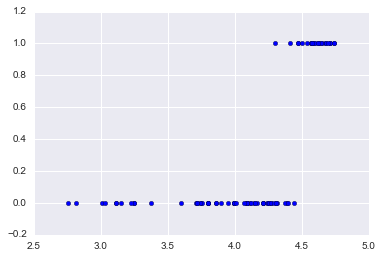

In [156]:
LogicRatingdf=Ratingdf
#Calculate the percent of excellent rating for each hotel
LogicRatingdf['Percent']=(LogicRatingdf['Excellent']/(LogicRatingdf['Excellent']+LogicRatingdf['Very Good']+LogicRatingdf['Average']+LogicRatingdf['Poor']+LogicRatingdf['Terrible']))*100
#define the Variable _excellent_ which 1 for hotel more than 60 otherwise 0 
LogicRatingdf['_excellent_'] = np.where(LogicRatingdf['Percent']> 60, 1.0, 0.0)
LogicRating=LogicRatingdf.drop(['Percent'],axis=1)
print("-------LOGICAL DATA FOR EXELLENCY OF BOSTON HOTELS-----------")
print LogicRating
#Scatter plot of _excellent_ against Avg_Score of hotel
plt.scatter(LogicRating['Avg_Score'],LogicRating['_excellent_'])

In [167]:
# print LogicRating
# print ("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
# print summaryres
# print ("############################")
# print Reviewdf
LogicFinaldf=pd.merge(pd.merge(LogicRating, summaryres, right_index=True, left_index=True),Reviewdf,right_index=True,left_index=True)
# LogicFinaldf=Finaldf.drop(['Terrible','Poor','Average','Very Good','Excellent'],axis=1)

# print LogicFinaldf.columns.values
# print LogicFinaldf.index.values
# print LogicFinaldf.dtypes
# print LogicFinaldf
# print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")

#remove one tupple which has null value for one of the attribute into new DataFrame LogicFinaldf_no_missing
LogicFinaldf_no_missing = LogicFinaldf.dropna() 
# print LogicFinaldf_no_missing.dtypes

#define y (dependent variable or logical variable  for Logistic Regression)
y= LogicFinaldf_no_missing._excellent_;
# print y
# print type(y)
# print y.shape

#define the training column for Logistic Regression
X=LogicFinaldf_no_missing[['Cleanliness','Location','Rooms','Service','Sleep Quality','Value','Business','Couples','Family','Friends','Solo']]
# X=LogicFinaldf[['Cleanliness','Location','Rooms','Service','Sleep Quality','Value','Business','Couples','Family','Friends','Solo']].values 
# print X
# print X.shape
# print type(X)

#Logistic Regression
logit = sm.Logit(y,X)
 # fit the model
result = logit.fit() 
print("-------------LOGISTIC REGRESSION MODEL ------------------------")
print result.summary()


Optimization terminated successfully.
         Current function value: 0.247389
         Iterations 9
-------------LOGISTIC REGRESSION MODEL ------------------------
                           Logit Regression Results                           
Dep. Variable:            _excellent_   No. Observations:                  109
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                           10
Date:                Tue, 29 Mar 2016   Pseudo R-squ.:                  0.5795
Time:                        23:56:59   Log-Likelihood:                -26.965
converged:                       True   LL-Null:                       -64.135
                                        LLR p-value:                 6.399e-12
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Cleanliness     -34.7391      8.892   

Analysis of Logistic Regression Model:
    We are using Logit model for logistic variable _excellent_  and rest column of DataFrame ie Review Type and Summary Data and Average Score as training data columns(12 columns) for no of observation 81. The pseudo R-Square  value is 0.57 which means the Logistic model fits 57 %. This Model cover 57 % of the observations.
    Again we see that summary rating data is more correlated than review type data which make sense.
    We see that Attributes like Room rating have stronger effect on excellency than other attribute because as the experience with the room is the primary need a customer has with the hotel. But with , location, sleep quality, service and Cleanliness actually decrease the likelihood of "excellency." This can be considered as high expectation of customer for these factors. Cleanliness, which is the most negative among them, is probably the easiest for a consumer to criticize when expecting the best.
    Coefficient values for Rooms is positively correlated which means for hotel with good Rooms rating has rating which is more than 60 % excellent ie hotel is excellency. So excellency depends on Rooms Quality , Service, Sleep Quality, Location, value and Cleanliness in that order. Review type is equal to almost zero indicating no correaltion to excellency of hotel. Ave_Score is weighted score fo each hotel from all ratings and we have high coefficient value as excellency crieteria is based on more then 60% ratings as excellent(5 stars).
    

-------

In [1]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("/Users/vsanghvi007/Github/theme/custom.css", "r").read()
    return HTML(styles)
css_styling()